# Thermostat

Example taken from: Chaudhuri, S., & Solar-Lezama, A. (2010, June). Smooth interpretation. In Proceedings of the 31st ACM SIGPLAN Conference on Programming Language Design and Implementation (pp. 279-291).

```
tOff = ?, tOn = ?

repeat {
    temp = readTemp()
    if isOn() and temp > tOff {
        isOn = False
    }
    else if not isOn() and temp < tOn {
        isOn = True
    }
}
```

Temperature evolves according to:
$$ \frac{d \textit{temp}}{dt} = \begin{cases} -k \cdot \textit{temp} + h \, (+ \text{gauss}(0, \epsilon)) & \text{if isON} \\
                                              -k \cdot \textit{temp} \, (+ \text{gauss}(0, \epsilon)) & \text{is not isOn}  \end{cases} $$

I generate temperature trajectories for $tOn =, tOff=, k=, h=, \epsilon=$ and try to synthesize $tOn, tOff$ using as loss the log-likelihood over trajectories.

In [1]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *
from time import time

torch.set_default_dtype(torch.float64)

### Original model

In [2]:
def orig_model(T=10, init_T=17., tOn=18, tOff=20, k=0.01, h=0.5, eps=0.5):
    traj = torch.zeros(T)
    isOn = False
    traj[0] = 16.
    noise = distributions.Normal(torch.tensor(0.), torch.tensor(eps))
    
    for i in range(1,T):
        
        #update temperature
        if isOn:
            traj[i] = traj[i-1] -k*traj[i-1] + h + noise.rsample() 
        else:
            traj[i] = traj[i-1] -k*traj[i-1] + noise.rsample() 

        # update thermostat state
        if isOn and traj[i] > tOff:
            isOn = False
        elif not isOn and traj[i] < tOn:
            isOn = True
            
    return traj        

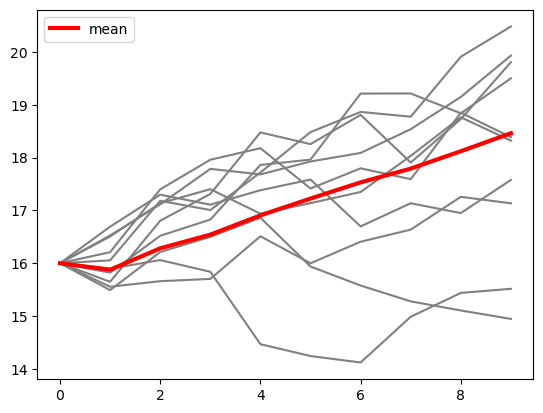

In [3]:
# generation of a set of trajectories

import matplotlib.pyplot as plt

traj_set = []
for _ in range(100):
    traj_set.append(orig_model())
traj_set = torch.vstack(traj_set)

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(10), traj_set[i], color='grey')

plt.plot(range(10), torch.mean(traj_set, 0), lw=3, color='red', label='mean')
plt.legend()

### SOGA program

In [4]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/Thermostat.soga')
cfg = produce_cfg(compiledFile)

pars = {'tOff':22., 'tOn':16.}

params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

output_dist = start_SOGA(cfg, params_dict)

In [5]:
output_dist.gm.mean()

tensor([16.0000, 15.8399, 15.9940, 16.2165, 16.4697, 16.7399, 17.0205, 17.3076,
        17.5988, 17.8923, 18.4779, 18.4779,  0.8845, 18.4779],
       grad_fn=<SumBackward1>)

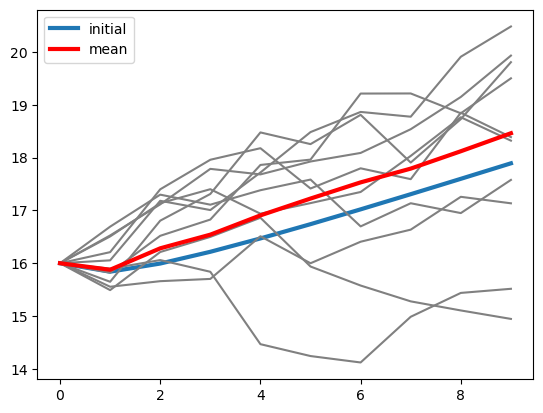

In [6]:
import matplotlib.pyplot as plt

y_init = output_dist.gm.mean()[:10].detach()
plt.plot(range(10), y_init, lw=3, label='initial')

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(10), traj_set[i], color='grey')

plt.plot(range(10), torch.mean(traj_set, 0), lw=3, color='red', label='mean')
plt.legend()

In [7]:
def neg_log_likelihood(traj_set, dist):
    idx = [1,2,3,4,5,6,7,8,9]
    log_likelihood = torch.log(dist.gm.marg_pdf(traj_set[:, idx].unsqueeze(0), idx))
    return - torch.sum(log_likelihood)

def L2_distance(traj_set, dist):
    idx = [1,2,3,4,5,6,7,8,9]
    output_traj = dist.gm.mean()[idx]
    return torch.sum(torch.pow(traj_set[:, idx] - output_traj,2))

neg_log_likelihood(traj_set, output_dist)
        

tensor(718.7436, grad_fn=<NegBackward0>)

In [8]:
# Define the optimizer with init_mean as the parameter

#torch.autograd.set_detect_anomaly(True)
pars = {'tOff':22., 'tOn':16.}

params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.05)

total_start = time()

for i in range(50):

    optimizer.zero_grad()  # Reset gradients
    
    # loss
    current_dist = start_SOGA(cfg, params_dict)

    loss = neg_log_likelihood(traj_set, current_dist)

    # Backpropagate
    loss.backward()
    
    optimizer.step()

    
    # Print progress
    if i % 10 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item()) + ' '
        out = out + f" loss: {loss.item()}"
        print(out)

total_end = time()

print('Optimization performed in ', round(total_end-total_start, 3))


tOff: 22.049999999847383 tOn: 16.04999999999786  loss: 718.7436158332979
tOff: 22.516069345582988 tOn: 16.49226152602493  loss: 665.0174685094462
tOff: 22.841341657191652 tOn: 16.764861926818064  loss: 658.4845047058304
tOff: 23.005842508846357 tOn: 16.904622250713846  loss: 657.5404284470299
tOff: 23.06152137025278 tOn: 16.98020517303457  loss: 657.2163805489037
Optimization performed in  41.104


In [9]:
params_dict

{'tOff': tensor(23.0609, requires_grad=True),
 'tOn': tensor(17.0250, requires_grad=True)}

In [10]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/Thermostat.soga')
cfg = produce_cfg(compiledFile)
output_dist = start_SOGA(cfg, params_dict)

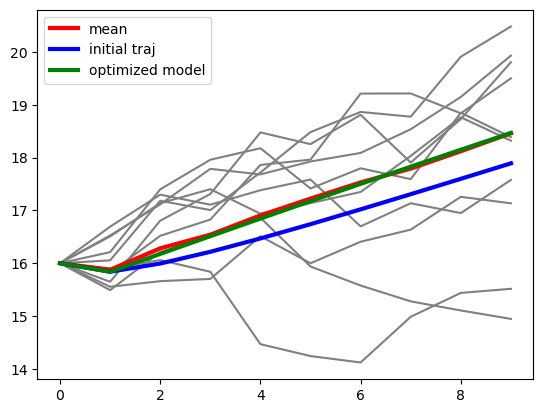

In [11]:
import matplotlib.pyplot as plt

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(10), traj_set[i], color='grey')

plt.plot(range(10), torch.mean(traj_set, 0), lw=3, color='red', label='mean')

plt.plot(range(10), y_init, lw=3, color='blue', label='initial traj')

plt.plot(range(10), output_dist.gm.mean()[:10].detach(), lw=3, color='green', label='optimized model')

plt.legend()

## Profiling

In [12]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/Thermostat.soga')
cfg = produce_cfg(compiledFile)

pars = {'tOff':22., 'tOn':16.}

params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

import cProfile
import pstats

# Profile the code
profiler = cProfile.Profile()
profiler.enable()
output_dist = start_SOGA(cfg, params_dict)
profiler.disable()

# Create a Stats object
stats = pstats.Stats(profiler)

# Sort the stats by total time and print them
stats.sort_stats('cumtime').print_stats()

         323234 function calls (320406 primitive calls) in 0.572 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.572    0.286 c:\Users\birik\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3541(run_code)
        2    0.000    0.000    0.572    0.286 {built-in method builtins.exec}
        1    0.000    0.000    0.572    0.572 C:\Users\birik\AppData\Local\Temp\ipykernel_2364\3272690005.py:1(<module>)
        1    0.001    0.001    0.572    0.572 c:\Users\birik\github\SOGA\src\libSOGA.py:36(start_SOGA)
      227    0.005    0.000    0.571    0.003 c:\Users\birik\github\SOGA\src\libSOGA.py:64(SOGA)
       88    0.001    0.000    0.334    0.004 c:\Users\birik\github\SOGA\src\libSOGAtruncate.py:218(truncate)
       88    0.013    0.000    0.248    0.003 c:\Users\birik\github\SOGA\src\libSOGAtruncate.py:25(ineq_func)
      116    0.001    0.000    0.219    0.002 c:\Users\birik\githu

In [ ]:
# Define the optimizer with init_mean as the parameter

from time import time
forward_time = []
loss_time = []
backward_time = []

#torch.autograd.set_detect_anomaly(True)
pars = {'tOff':22., 'tOn':16.}

params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.05)

total_start = time()

for i in range(50):

    optimizer.zero_grad()  # Reset gradients
    
    # loss
    start = time()
    current_dist = start_SOGA(cfg, params_dict)
    end = time()
    forward_time.append(end-start)

    start = time()
    loss = neg_log_likelihood(traj_set, current_dist)
    end = time()
    loss_time.append(end-start)
        
    # Backpropagate
    start = time()
    loss.backward()
    end = time()
    backward_time.append(end-start)
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 10 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item()) + ' '
        out = out + f" loss: {loss.item()}"
        print(out)

total_end = time()

print('Optimization performed in ', round(total_end-total_start, 3))

print('Time for forward computation', torch.mean(torch.tensor(forward_time)))
print('Time for loss computation', torch.mean(torch.tensor(loss_time)))
print('Time for backward computation', torch.mean(torch.tensor(backward_time)))


tOff: 22.049999999847383 tOn: 16.04999999999786  loss: 718.7436158332979
tOff: 22.516069345582988 tOn: 16.49226152602493  loss: 665.0174685094462
tOff: 22.841341657191652 tOn: 16.764861926818064  loss: 658.4845047058304
tOff: 23.005842508846357 tOn: 16.904622250713846  loss: 657.5404284470299
tOff: 23.06152137025278 tOn: 16.98020517303457  loss: 657.2163805489037
Optimization performed in  38.922
Time for forward computation tensor(0.4518)
Time for loss computation tensor(0.0265)
Time for backward computation tensor(0.2997)


In [14]:
print('Total time for forward computation', torch.sum(torch.tensor(forward_time)))
print('Total time for loss computation', torch.sum(torch.tensor(loss_time)))
print('Total time for backward computation', torch.sum(torch.tensor(backward_time)))


Total time for forward computation tensor(22.5880)
Total time for loss computation tensor(1.3255)
Total time for backward computation tensor(14.9842)


In [ ]:
#### Before optimization
'''
Total time for forward computation tensor(56.8369)
Total time for loss computation tensor(1.6743)
Total time for backward computation tensor(25.0452)
'''

'\nTotal time for forward computation tensor(56.8369)\nTotal time for loss computation tensor(1.6743)\nTotal time for backward computation tensor(25.0452)\n'

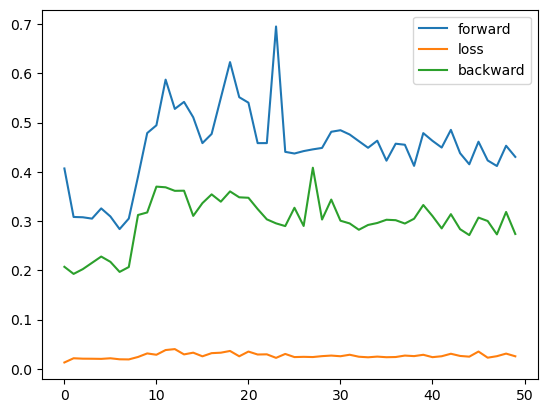

In [15]:
plt.plot(range(len(forward_time)), forward_time, label='forward')
plt.plot(range(len(loss_time)), loss_time, label='loss')
plt.plot(range(len(backward_time)), backward_time, label='backward')
plt.legend()